# Text Sentiment Classification By LSTM

In [ ]:
# ignores all warnings and prevents them from being printed to the console.
import warnings
warnings.filterwarnings('ignore')
path_prefix = './'

## 1. Data Loading [def load_training_data, def load_training _data, def evaluation]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F

def load_training_data(path='/content/drive/MyDrive/CityU/ Courses/3. Junior/Semester B/SDSC4016_ML2/SDSC4016_Group Project/Project/TrainMerge.txt'):
    # Read training data
    if '/content/drive/MyDrive/CityU/ Courses/3. Junior/Semester B/SDSC4016_ML2/SDSC4016_Group Project/Project/TrainMerge.txt' in path:
        with open(path, 'r',encoding='utf-8') as f:
            lines = f.readlines()
            lines = [line.strip('\n').split(' ') for line in lines]
        x = [line[2:] for line in lines]
        y = [line[0] for line in lines]
        return x, y
    else:
        with open(path, 'r',encoding='utf-8') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
        return x

def load_testing_data(path='/content/drive/MyDrive/CityU/ Courses/3. Junior/Semester B/SDSC4016_ML2/SDSC4016_Group Project/Project/TestMerge.txt'):
    # Read testing data
    with open(path, 'r',encoding='utf-8') as f:
        lines = f.readlines()
        X = ["".join(line.strip('\n').split(",")[0:]).strip() for line in lines[0:]]
        X = [sen.split(' ') for sen in X]
        Y = [line[0] for line in lines]
    return X, Y

def evaluation(outputs, labels):
    #outputs => probability (float)
    #labels => labels
    outputs[outputs>=0.8] = 1 # Negtive Sentiment
    outputs[outputs<0.8] = 0 # Positive Sentiment
    correct = torch.sum(torch.eq(outputs, labels)).item()
    return correct

## 2. Train Word to Vector

In [ ]:
import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
    model = word2vec.Word2Vec(x, vector_size=250, window=5, min_count=5, workers=12)
    return model

if __name__ == "__main__":
    print("loading training data ...")
    train_x, y = load_training_data() # /content/drive/MyDrive/CityU/ Courses/3. Junior/Semester B/SDSC4016_ML2/SDSC4016_Group Project/HW3/Train_label.txt
    #train_x_no_label = load_training_data() # /content/drive/MyDrive/CityU/ Courses/3. Junior/Semester B/SDSC4016_ML2/SDSC4016_Group Project/HW3/Train_nolabel.txt

    print("loading testing data ...")
    test_x, Y = load_testing_data() # /content/drive/MyDrive/CityU/ Courses/3. Junior/Semester B/SDSC4016_ML2/SDSC4016_Group Project/HW3/Test.txt

    model = train_word2vec(train_x + test_x) # (train_x + train_x_no_label + test_x)
    
    print("saving model ...")
    model.save(os.path.join(path_prefix, 'w2v_all.model'))

loading training data ...
loading testing data ...
saving model ...


In [ ]:
# coptest_x = test_x.copy()

In [ ]:
# coptest_x = np.array(coptest_x)
# coptest_x.shape

(1053,)

## 3. Data Preprocess [class preprocess]


In [ ]:
from torch import nn
from gensim.models import Word2Vec

class Preprocess():
    def __init__(self, sentences, sen_len, w2v_path="./w2v.model"):
        self.w2v_path = w2v_path
        self.sentences = sentences
        self.sen_len = sen_len
        self.idx2word = []
        self.word2idx = {}
        self.embedding_matrix = []
    def get_w2v_model(self):
        # load word to vector model
        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size
    def add_embedding(self, word):
        # add word into embedding
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2idx[word] = len(self.word2idx)
        self.idx2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)
    def make_embedding(self, load=True):
        print("Get embedding ...")
        if load:
            print("loading word to vec model ...")
            self.get_w2v_model()
        else:
            raise NotImplementedError

        for i, word in enumerate(self.embedding.wv.key_to_index):
            print('get words #{}'.format(i+1), end='\r')
            self.word2idx[word] = len(self.word2idx)
            self.idx2word.append(word)
            self.embedding_matrix.append(self.embedding.wv[word])
        print('')
        self.embedding_matrix = torch.tensor(self.embedding_matrix)
        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))
        return self.embedding_matrix
    def pad_sequence(self, sentence):
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2idx["<PAD>"])
        assert len(sentence) == self.sen_len
        return sentence
    def sentence_word2idx(self):
        sentence_list = []
        for i, sen in enumerate(self.sentences):
            print('sentence count #{}'.format(i+1), end='\r')
            sentence_idx = []
            for word in sen:
                if (word in self.word2idx.keys()):
                    sentence_idx.append(self.word2idx[word])
                else:
                    sentence_idx.append(self.word2idx["<UNK>"])
            sentence_idx = self.pad_sequence(sentence_idx)
            sentence_list.append(sentence_idx)
        return torch.LongTensor(sentence_list)
    def labels_to_tensor(self, y):
        # turn labels into tensors
        y = [int(label) for label in y]
        return torch.LongTensor(y)

## 4. Dataset [class Amazon dataset]

In [ ]:
import torch
from torch.utils import data

class AmazonDataset(data.Dataset):
    """
    Expected data shape like:(data_num, data_len)
    Data can be a list of numpy array or a list of lists
    input data shape : (data_num, seq_len, feature_dim)
    
    __len__ will return the number of data
    """
    def __init__(self, X, y):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

## 5. Model NN Structure [class ]

In [ ]:
import torch
from torch import nn

### 5.1 LTSM Model

In [ ]:
class LSTM_Net(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(LSTM_Net, self).__init__()
        # embedding layer
        self.embedding = torch.nn.Embedding(embedding.size(0),embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding)
        # Whether fix embedding
        self.embedding.weight.requires_grad = False if fix_embedding else True
        self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim, 1),
                                         nn.Sigmoid() )
    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.lstm(inputs, None)
        # dimension of x (batch, seq_len, hidden_size)
        x = x[:, -1, :] 
        x = self.classifier(x)
        return x

### 5.2 Text Recurrent Convol. NN model

In [ ]:
#CG ^^^^^ TextRCNN

class TextRCNN(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(TextRCNN, self).__init__()

        # embedding layer
        self.embedding = nn.Embedding(embedding.size(0), embedding.size(1))
        self.embedding.weight = nn.Parameter(embedding)
        # Whether fix embedding
        self.embedding.weight.requires_grad = False if fix_embedding else True
#         self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Bidirectional LSTM
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=False)
        self.W2 = nn.Linear(2*hidden_dim+embedding_dim, hidden_dim) #new CG
        self.classifier = nn.Sequential( nn.Dropout(dropout),
                                          nn.Linear(hidden_dim, 1),
                                          nn.Sigmoid() )

    def forward(self, inputs):
#         inputs = self.embedding(inputs)
#         x, _ = self.lstm(inputs, None)
#         # dimension of x (batch, seq_len, hidden_size)
#         x = x[:, -1, :] 

        # Embedding
        x = self.embedding(inputs)  # shape: (batch_size, seq_len, embedding_dim)

        # Bidirectional LSTM
        lstm_out, _ = self.lstm(x)  # shape: (batch_size, seq_len, 2*hidden_dim)

        # Concatenation of contextualized embeddings
        x = torch.cat((x, lstm_out), dim=2)  # shape: (batch_size, seq_len, 2*hidden_dim+embedding_dim)

        # Two-layer feedforward neural network
        x = torch.tanh(self.W2(x))  # shape: (batch_size, seq_len, hidden_dim)

        # Max-pooling
        x = torch.max(x, dim=1)[0]  # shape: (batch_size, hidden_dim)

        # Classifier
        x = self.classifier(x)
        return x

### 5.3 Text Bidirectional LTSM + Attention model

In [ ]:
#CG ^^^^^ Text Bi LSTM Attention

class TextBiLSTMAttention(nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, fix_embedding=True):
        super(TextBiLSTMAttention, self).__init__()

        # embedding layer
        self.embedding = nn.Embedding(embedding.size(0), embedding.size(1))
        self.embedding.weight = nn.Parameter(embedding)
        # Whether fix embedding
        self.embedding.weight.requires_grad = False if fix_embedding else True
#         self.embedding_dim = embedding.size(1)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        # Bidirectional LSTM
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)

        # Attention layer new CG
        self.attention_layer = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*2, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
#         inputs = self.embedding(inputs)
#         x, _ = self.lstm(inputs, None)
#         # dimension of x (batch, seq_len, hidden_size)
#         x = x[:, -1, :] 
#         x = self.classifier(x)

        # Embedding
        x = self.embedding(inputs)  # shape: (batch_size, seq_len, embedding_dim)

        # Bidirectional LSTM
        lstm_out, _ = self.lstm(x)  # shape: (batch_size, seq_len, 2*hidden_dim)

        # Attention
        attention_weights = self.attention_layer(lstm_out).squeeze(dim=-1)  # shape: (batch_size, seq_len)
        attention_weights = attention_weights.unsqueeze(dim=-1)  # shape: (batch_size, seq_len, 1)
        context_vector = (lstm_out * attention_weights).sum(dim=1)  # shape: (batch_size, hidden_dim*2)

        # Classifier
        x = self.classifier(context_vector)
        return x

## 6. Define Training [def training]

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))
    model.train() # set training mode
    criterion = nn.BCELoss() # Define loss function
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr) # ,betas=(0.9, 0.999)set optimizer as SGD (you can change it)
    total_loss, total_acc, best_acc = 0, 0, 0

    train_loss_history, valid_loss_history = [], [] # add to track loss history 
    train_acc_history, valid_acc_history = [], []  # add to track accuracy history 

    for epoch in range(n_epoch):
        total_loss, total_acc = 0, 0
        
        # For training
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) # set device "cuda"
            labels = labels.to(device, dtype=torch.float) # set device "cuda"
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            correct = evaluation(outputs, labels) # calculate accuracy
            total_acc += (correct / batch_size)
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_batch, loss.item(), correct*100/batch_size), end='\r')
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_batch, total_acc/t_batch*100))
        
        train_acc = total_acc / t_batch
        train_loss = total_loss / t_batch
        # Append the training accuracy to the history
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(train_loss, train_acc*100)) 

        # For validation
        model.eval() # set validation mode
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) # set device "cuda"
                labels = labels.to(device, dtype=torch.float) # set device "cuda"
                outputs = model(inputs)
                outputs = outputs.squeeze()
                loss = criterion(outputs, labels)
                correct = evaluation(outputs, labels)
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            valid_acc = total_acc / v_batch
            valid_loss = total_loss / v_batch
            # Append the validation accuracy to the history
            valid_acc_history.append(valid_acc)
            valid_loss_history.append(valid_loss)

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            if valid_acc  > best_acc:
                # if the result of validation is better than previous model, save the new model
                best_acc = valid_acc 
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(valid_acc*100))
        
        

        print('-----------------------------------------------')
        model.train()

    return train_acc_history, valid_acc_history, train_loss_history, valid_loss_history

## 7. Define Testing [def testing]

In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            outputs[outputs>=0.8] = 1
            outputs[outputs<0.8] = 0
            ret_output += outputs.int().tolist()
    
    return ret_output

## 8. Parameter setting + Call function Train!!

In [ ]:
# main.py
import os
import torch
import argparse
import numpy as np
from torch import nn
from gensim.models import word2vec
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set data path
train_with_label = os.path.join(path_prefix, 'Train_label.txt')
train_no_label = os.path.join(path_prefix, 'Train_nolabel.txt')
testing_data = os.path.join(path_prefix, 'Test.txt')
w2v_path = os.path.join(path_prefix, 'w2v_all.model')


sen_len = 60 #from 30
fix_embedding = True # fix embedding during training
batch_size = 64 # from 128
epoch = 50 # from 2
lr = 0.001
model_dir = path_prefix

print("loading data ...")
train_x, y = load_training_data() #(train_with_label)
# train_x_no_label = load_training_data(train_no_label)

# Preprocessing
preprocess = Preprocess(train_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
train_x = preprocess.sentence_word2idx()
y = preprocess.labels_to_tensor(y)

        # CG
# model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=250, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
# model = TextRCNN(embedding, embedding_dim=250, hidden_dim=250, num_layers=3, dropout=0.2, fix_embedding=fix_embedding)

model = TextBiLSTMAttention(embedding, embedding_dim=250, hidden_dim=250, num_layers=2, dropout=0.2, fix_embedding=fix_embedding)

model = model.to(device) # device為"cuda"，model使用GPU來訓練(餵進去的inputs也需要是cuda tensor)

X_train, X_val, y_train, y_val = train_x[:3369], train_x[3369:], y[:3369], y[3369:]
# X_train, X_val, y_train, y_val = train_x[:130000], train_x[130000:], y[:130000], y[130000:]

train_dataset = AmazonDataset(X = X_train, y = y_train)
val_dataset = AmazonDataset(X = X_val, y = y_val)

# transfor data into batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 0)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)
#%%
# Begin Training
train_acc_history, valid_acc_history, train_loss_history, valid_loss_history = training(batch_size, epoch, lr, model_dir, train_loader, val_loader, model, device)

loading data ...
Get embedding ...
loading word to vec model ...
get words #4923
total words: 4925

start training, parameter total:3865252, trainable:2634002

[ Epoch1: 53/53 ] loss:0.373 acc:56.250 
Train | Loss:0.33963 Acc: 77.182

Train | Loss:0.33963 Acc: 77.182
Valid | Loss:0.33158 Acc: 79.799 
saving model with acc 79.799
-----------------------------------------------
[ Epoch2: 53/53 ] loss:0.202 acc:56.250 
Train | Loss:0.31110 Acc: 83.432

Train | Loss:0.31110 Acc: 83.432
Valid | Loss:0.32021 Acc: 79.241 
-----------------------------------------------
[ Epoch3: 53/53 ] loss:0.295 acc:54.688 
Train | Loss:0.30893 Acc: 84.935

Train | Loss:0.30893 Acc: 84.935
Valid | Loss:0.31290 Acc: 78.237 
-----------------------------------------------
[ Epoch4: 53/53 ] loss:0.494 acc:45.312 
Train | Loss:0.31008 Acc: 83.933

Train | Loss:0.31008 Acc: 83.933
Valid | Loss:0.31536 Acc: 79.911 
saving model with acc 79.911
-----------------------------------------------
[ Epoch5: 53/53 ] loss

## 9. Plotting Accuracy and Validation

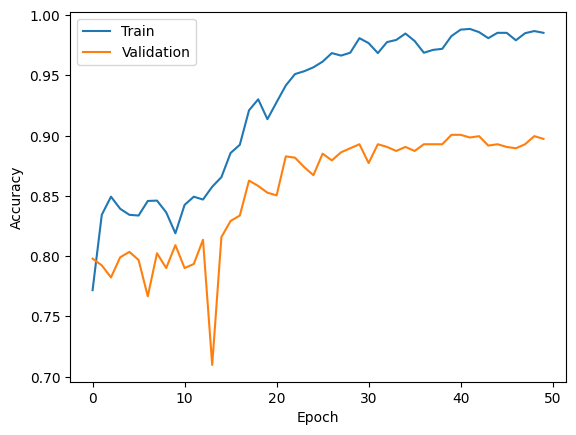

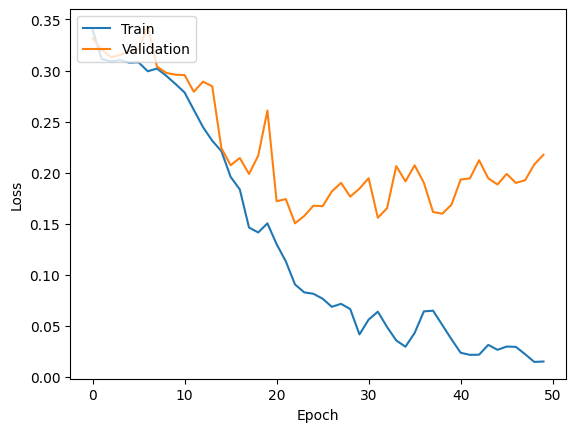

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the LOSS history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 10. Predict, test accuracy, and save to csv file

In [ ]:
print("loading testing data ...")
test_x, Y = load_testing_data() #(testing_data)
preprocess = Preprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding(load=True)
test_x = preprocess.sentence_word2idx()
test_dataset = AmazonDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 0)
print('\nload model ...')
model = torch.load(os.path.join(model_dir, 'ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

# save as csv
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"labels":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'predict.csv'), index=False)
print("Finish Predicting")

loading testing data ...
Get embedding ...
loading word to vec model ...
get words #4923
total words: 4925
sentence count #1053
load model ...
save csv ...
Finish Predicting


In [ ]:
# del Y[1052]

Y = np.array(Y)
Y = Y.astype(int)
# Y.dtype

outputs = np.array(outputs)
# outputs.dtype

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y, outputs)
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9088


# Hint
* Optimizer
* learning rate
* epoch
* batch size
* Activation function
* Self-Training for unlabel training data